<a href="https://colab.research.google.com/github/zahrasa/Food_classification/blob/main/food_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# import libraries
%%capture

import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import itertools
from IPython.display import display, Image
from pathlib import Path
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import regularizers
import tensorflow_hub as hub
import seaborn as sns

In [ ]:
!pip install --upgrade --no-cache-dir gdown

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for gdown: filename=gdown-4.4.0-py3-none-any.whl size=14774 sha256=32712ca78288ba5303d680c93c182691eedbf3caf4ca20e2a6e6d36754f2f6cf
  Stored in directory: /tmp/pip-ephem-wheel-cache-u7ronafl/wheels/fb/c3/0e/c4d8ff8bfcb0461afff199471449f642179b74968c15b7a69c
Successfully built gdown
  Attempting uninstall: gdown
    Found existing installation: gdown 4.2.2
    Uninstalling gdown-4.2.2:
      Successfully uninstalled gdown-4.2.2


In [ ]:
# Download the dataset
! rm -rf * 
! gdown --id 1WtrFwCpNThjoQPM4U_iuE7KNg-IDpKGS

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1WtrFwCpNThjoQPM4U_iuE7KNg-IDpKGS
To: /content/Food-Data.zip
100% 293M/293M [00:01<00:00, 157MB/s]


In [ ]:
! unzip "Food-Data.zip"
! rm -r "Food-Data.zip"

In [ ]:
# Set Variables

data_dir = Path("Food-Data")
train_dir = data_dir/"training"
test_dir = data_dir/"test"

In [ ]:
# let's see our classes
os.listdir(train_dir)

['Seafood', 'Meat', 'Fried food', 'Rice', 'Egg']

In [ ]:
# create a list for file paths

path_list = list(map(lambda x:list(map(lambda y:os.path.join(train_dir,x,y),os.listdir(os.path.join(train_dir,x)))), os.listdir(train_dir)))
path_list = list(itertools.chain.from_iterable(path_list)) # make o flat list
path_list[0:10]

['Food-Data/training/Seafood/32.jpg',
 'Food-Data/training/Seafood/232.jpg',
 'Food-Data/training/Seafood/809.jpg',
 'Food-Data/training/Seafood/687.jpg',
 'Food-Data/training/Seafood/195.jpg',
 'Food-Data/training/Seafood/435.jpg',
 'Food-Data/training/Seafood/235.jpg',
 'Food-Data/training/Seafood/203.jpg',
 'Food-Data/training/Seafood/536.jpg',
 'Food-Data/training/Seafood/193.jpg']

In [ ]:
path_list[102]

'Food-Data/training/Seafood/606.jpg'

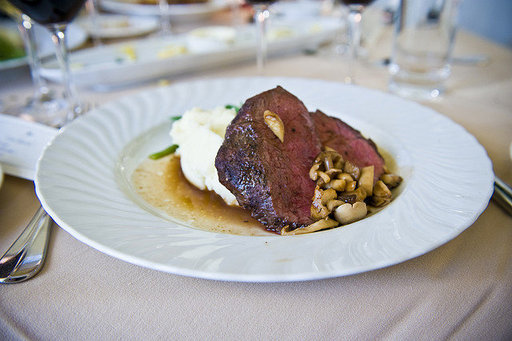

In [ ]:
Image(path_list[984])

In [ ]:
# create DataFrame from path_list
labels_df = pd.DataFrame({'path':path_list})
# get labels from path
labels_df['label'] = labels_df.path.apply(lambda x:x.split('/')[2])

labels_df.head()

,path,label
0,Food-Data/training/Seafood/32.jpg,Seafood
1,Food-Data/training/Seafood/232.jpg,Seafood
2,Food-Data/training/Seafood/809.jpg,Seafood
3,Food-Data/training/Seafood/687.jpg,Seafood
4,Food-Data/training/Seafood/195.jpg,Seafood


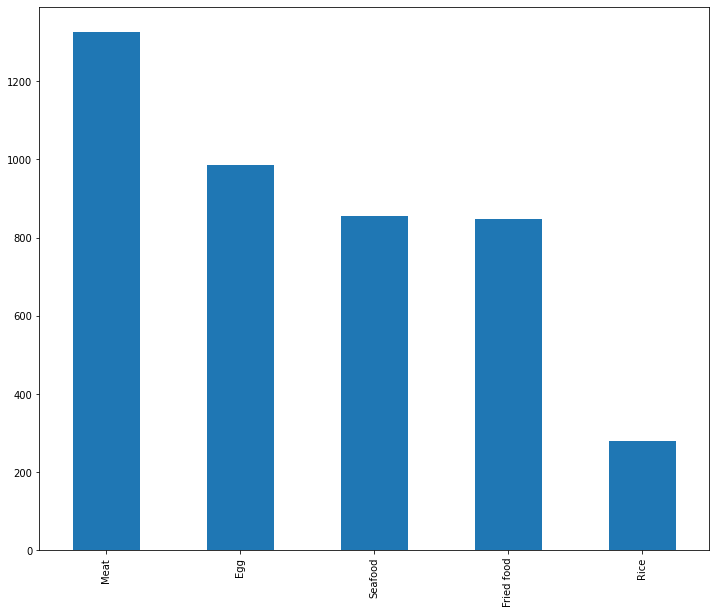

In [ ]:
# let's check label balance
labels_df.label.value_counts().plot(kind='bar',figsize = (12,10))

In [ ]:
unique_labels = np.unique(labels_df.label)
unique_labels

array(['Egg', 'Fried food', 'Meat', 'Rice', 'Seafood'], dtype=object)

In [ ]:
# we can create boolean label for each instance
boolean_labels = [label == unique_labels for label in labels_df.label]
boolean_labels[:2]

[array([False, False, False, False,  True]),
 array([False, False, False, False,  True])]

In [ ]:
# create list for paths and labels
X = labels_df.path.to_list()
y = boolean_labels
len(X) == len(y)

True

In [ ]:
# create train and validation test
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=1400)
len(X_train),len(X_val),len(y_train),len(y_val)

(3435, 859, 3435, 859)

In [ ]:
# Define image size
IMG_SIZE = 224

def process_image(image_path):
  """
  Takes an image file path and turns it into a Tensor.
  """
  # Read in image file
  image = tf.io.read_file(image_path)
  # Turn the jpeg image into numerical Tensor with 3 colour channels (Red, Green, Blue)
  image = tf.image.decode_jpeg(image, channels=3)
  # Convert the colour channel values from 0-225 values to 0-1 values
  image = tf.image.convert_image_dtype(image, tf.float32)
  # Resize the image to our desired size (224, 244)
  image = tf.image.resize(image, size=[IMG_SIZE, IMG_SIZE])
  return image

In [ ]:
# Create a simple function to return a tuple (image, label)
def get_image_label(image_path, label):
  """
  Takes an image file path name and the associated label,
  processes the image and returns a tuple of (image, label).
  """
  image = process_image(image_path)
  return image, label

In [ ]:
# Define the batch size, 32 is a good default
BATCH_SIZE = 64

# Create a function to turn data into batches
def create_data_batches(x, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
  """
  Creates batches of data out of image (x) and label (y) pairs.
  Shuffles the data if it's training data but doesn't shuffle it if it's validation data.
  Also accepts test data as input (no labels).
  """
  # If the data is a test dataset, we probably don't have labels
  if test_data:
    print("Creating test data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x))) # only filepaths
    data_batch = data.map(process_image).batch(BATCH_SIZE)
    return data_batch
  
  # If the data if a valid dataset, we don't need to shuffle it
  elif valid_data:
    print("Creating validation data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x), # filepaths
                                               tf.constant(y))) # labels
    data_batch = data.map(get_image_label).batch(BATCH_SIZE)
    return data_batch

  else:
    # If the data is a training dataset, we shuffle it
    print("Creating training data batches...")
    # Turn filepaths and labels into Tensors
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x), # filepaths
                                              tf.constant(y))) # labels
    
    # Shuffling pathnames and labels before mapping image processor function is faster than shuffling images
    data = data.shuffle(buffer_size=len(x))

    # Create (image, label) tuples (this also turns the image path into a preprocessed image)
    data = data.map(get_image_label)

    # Turn the data into batches
    data_batch = data.batch(BATCH_SIZE)
  return data_batch

In [ ]:
# Create training and validation data batches
train_data = create_data_batches(X_train, y_train)
val_data = create_data_batches(X_val, y_val, valid_data=True)

Creating training data batches...
Creating validation data batches...


In [ ]:
# Check out the different attributes of our data batches
train_data.element_spec, val_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 5), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 5), dtype=tf.bool, name=None)))

In [ ]:
import matplotlib.pyplot as plt

# Create a function for viewing images in a data batch
def show_25_images(images, labels):
  """
  Displays 25 images from a data batch.
  """
  # Setup the figure
  plt.figure(figsize=(10, 10))
  # Loop through 25 (for displaying 25 images)
  for i in range(25):
    # Create subplots (5 rows, 5 columns)
    ax = plt.subplot(5, 5, i+1)
    # Display an image
    plt.imshow(images[i])
    # Add the image label as the title
    plt.title(unique_labels[labels[i].argmax()])
    # Turn gird lines off
    plt.axis("off")

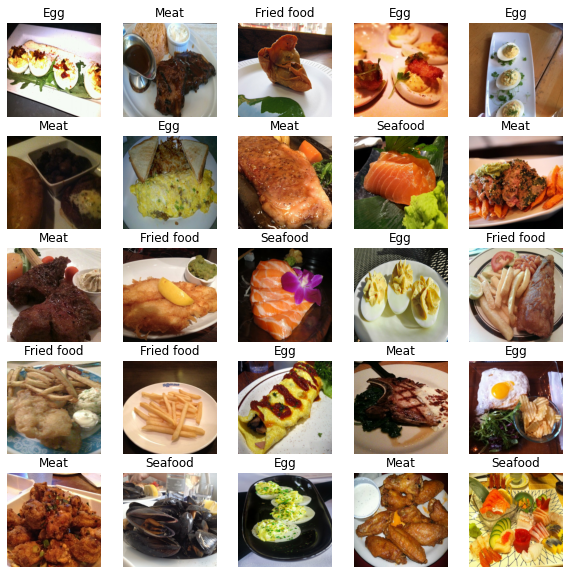

In [ ]:
# Visualize training images from the training data batch
train_images, train_labels = next(train_data.as_numpy_iterator())
show_25_images(train_images, train_labels)

In [ ]:
# Setup input shape to the model
INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE, 3] # batch, height, width, colour channels

# Setup output shape of the model
OUTPUT_SHAPE = len(unique_labels) # number of unique labels

# Setup model URL from TensorFlow Hub
MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v3_large_100_224/classification/5"

In [ ]:
#  Create a function which builds a Keras model
def create_model(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE, model_url=MODEL_URL):
  print("Building model with:", MODEL_URL)

  # Setup the model layers
  model = tf.keras.Sequential([
    hub.KerasLayer(MODEL_URL), # Layer 1 (input layer)s
    tf.keras.layers.Dense(units=128, activation="elu"),
    tf.keras.layers.Dense(units=32, activation="elu"),
    tf.keras.layers.Dense(units=OUTPUT_SHAPE, activation="softmax") # Layer 2 (output layer)
  ])

  # Compile the model
  model.compile(
      loss=tf.keras.losses.CategoricalCrossentropy(), # Our model wants to reduce this (how wrong its guesses are)
      optimizer=tf.keras.optimizers.Adam(), # A friend telling our model how to improve its guesses
      metrics=["accuracy"] # We'd like this to go up
  )

  # Build the model
  model.build(INPUT_SHAPE) # Let the model know what kind of inputs it'll be getting
  
  return model

In [ ]:
# Create a model and check its details
model = create_model()
model.summary()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v3_large_100_224/classification/5
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1001)              5508713   
                                                                 
 dense (Dense)               (None, 128)               128256    
                                                                 
 dense_1 (Dense)             (None, 32)                4128      
                                                                 
 dense_2 (Dense)             (None, 5)                 165       
                                                                 
Total params: 5,641,262
Trainable params: 132,549
Non-trainable params: 5,508,713
_________________________________________________________________


In [ ]:
# Create early stopping (once our model stops improving, stop training)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                  patience=5) # stops after 3 rounds of no improvements

In [ ]:
# Check again if GPU is available (otherwise computing will take a looooonnnnggggg time)
print("GPU", "available (YESS!!!!)" if tf.config.list_physical_devices("GPU") else "not available :(")

GPU available (YESS!!!!)


In [ ]:
# How many rounds should we get the model to look through the data?
NUM_EPOCHS = 20 #@param {type:"slider", min:1, max:100, step:1}

In [ ]:
# Build a function to train and return a trained model
def train_model():
  """
  Trains a given model and returns the trained version.
  """
  # Create a model
  model = create_model()

  # Fit the model to the data passing it the callbacks we created
  h = model.fit(x=train_data,
            epochs=NUM_EPOCHS,
            validation_data=val_data,
            validation_freq=1) # check validation metrics every epoch
  
  return model , h

In [ ]:
# Fit the model to the data
model , h = train_model()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v3_large_100_224/classification/5
Epoch 1/20
54/54 [==============================] - 36s 286ms/step - loss: 0.4542 - accuracy: 0.8309 - val_loss: 0.2998 - val_accuracy: 0.8952
Epoch 2/20
54/54 [==============================] - 16s 296ms/step - loss: 0.1426 - accuracy: 0.9531 - val_loss: 0.2941 - val_accuracy: 0.9069
Epoch 3/20
54/54 [==============================] - 14s 251ms/step - loss: 0.0834 - accuracy: 0.9738 - val_loss: 0.2948 - val_accuracy: 0.9045
Epoch 4/20
54/54 [==============================] - 14s 267ms/step - loss: 0.0437 - accuracy: 0.9901 - val_loss: 0.2934 - val_accuracy: 0.9069
Epoch 5/20
54/54 [==============================] - 14s 254ms/step - loss: 0.0214 - accuracy: 0.9971 - val_loss: 0.3186 - val_accuracy: 0.9127
Epoch 6/20
54/54 [==============================] - 14s 252ms/step - loss: 0.0118 - accuracy: 0.9991 - val_loss: 0.3121 - val_accuracy: 0.9069
Epoch 7/20
54/54 [=========================

In [ ]:
# Make predictions on the validation data (not used to train on)
predictions = model.predict(val_data, verbose=1) # verbose shows us how long there is to go
predictions

14/14 [==============================] - 4s 210ms/step


array([[1.0000000e+00, 1.6117005e-10, 1.8246813e-09, 6.8875652e-12,
        2.8136313e-10],
       [7.2154999e-13, 2.8856853e-08, 9.9999976e-01, 1.9643781e-07,
        4.0609703e-12],
       [2.7908023e-13, 1.2066596e-11, 9.9999905e-01, 1.5203887e-10,
        9.0882372e-07],
       ...,
       [1.3136395e-13, 3.7719475e-14, 1.2348148e-10, 1.0000000e+00,
        5.6935623e-11],
       [9.9999964e-01, 3.9928363e-08, 2.0802787e-07, 1.3241215e-09,
        9.4975071e-08],
       [1.0000000e+00, 2.8278848e-09, 5.9453820e-13, 5.3720990e-12,
        1.8267593e-10]], dtype=float32)

In [ ]:
# Turn prediction probabilities into their respective label (easier to understand)
def get_pred_label(prediction_probabilities):
  """
  Turns an array of prediction probabilities into a label.
  """
  return unique_labels[np.argmax(prediction_probabilities)]

# Get a predicted label based on an array of prediction probabilities
pred_label = get_pred_label(predictions[0])
pred_label

'Egg'

In [ ]:
# create list of predicted labels and actual labels
predictions_list = list(map(get_pred_label,predictions))
y_val_list = list(map(get_pred_label,y_val))

# evaluation model with validation data

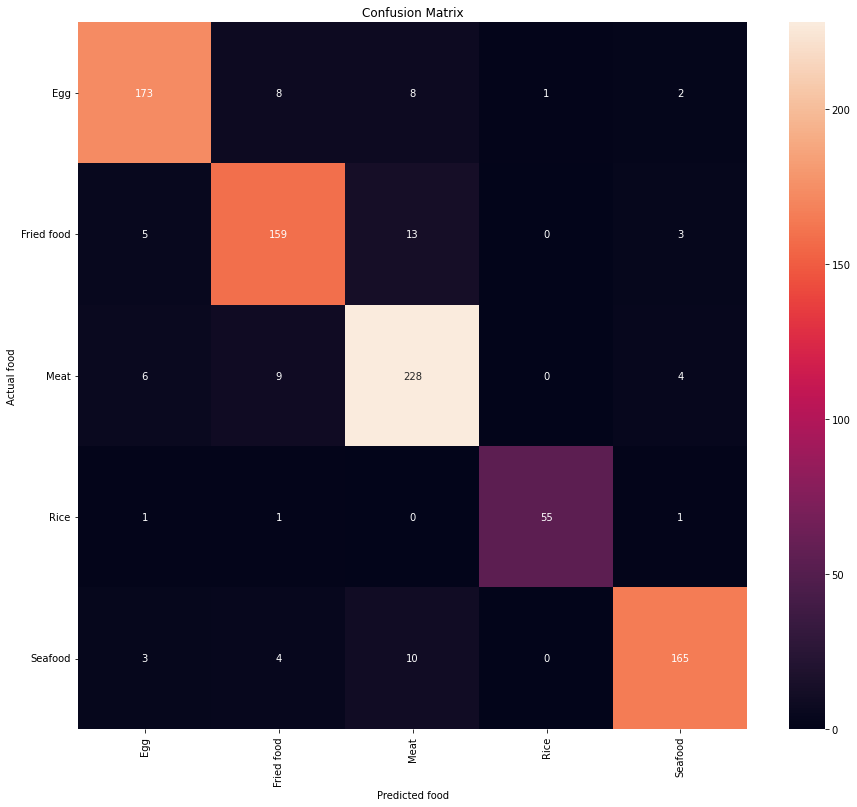

In [ ]:
# draw confusion matrix
cm = confusion_matrix(y_val_list, predictions_list)

fig, ax = plt.subplots(figsize=(15,13)) 
sns.heatmap(cm, annot=True, fmt='g',ax=ax);

ax.set_title('Confusion Matrix');
ax.set_xlabel('Predicted food')
ax.set_ylabel('Actual food');

ax.xaxis.set_ticklabels(unique_labels, rotation = 90)
ax.yaxis.set_ticklabels(unique_labels, rotation = 0)


plt.show()

In [ ]:
print(classification_report(y_val_list,predictions_list))

              precision    recall  f1-score   support

         Egg       0.92      0.90      0.91       192
  Fried food       0.88      0.88      0.88       180
        Meat       0.88      0.92      0.90       247
        Rice       0.98      0.95      0.96        58
     Seafood       0.94      0.91      0.92       182

    accuracy                           0.91       859
   macro avg       0.92      0.91      0.92       859
weighted avg       0.91      0.91      0.91       859



# save models!

In [ ]:
# save models
import datetime
model.save(datetime.datetime.now().strftime("%Y%m%d-%H%M%s") + '.h5')

In [ ]:
# ! gdown --id 1YKWqTOQ781uWR2CI1Rk-95i4mmB_wRcb

In [ ]:
# load model
# model = tf.keras.models.load_model('20211118-13561637243816.h5',custom_objects={"KerasLayer":hub.KerasLayer})